In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

# import MH_inference
# import HMC_inference
from pyhf_pymc import prepare_inference
# from pyhf_pymc import HMC_inference


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Model

In [2]:
N = 5
nBins = N
ur_obs = jnp.array([70., 70., 90., 90., 80.])
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N, [45]*N, [55]*N)
model.expected_actualdata(model.config.suggested_init()),model.config.suggested_init()

n_samples = 1000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=ur_obs, precision=8, priors=prior_dict)

## Sampling

In [3]:
from pyhf_pymc import actual_inference

In [5]:
post_data, post_pred, prior_pred = actual_inference.sampling(prepared_model, n_samples = 50, n_chains = 1, sampling_method='Metropolis')

Only 50 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]


Sampling 1 chain for 1_000 tune and 50 draw iterations (1_000 + 50 draws total) took 124 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (50) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/Users/malinhorstmann/Documents/pyhf_pymc/src/pyhf_pymc/actual_inference.py:78: UserWarning: The number of samples is too small to check convergence reliably.
  post_data = pm.sample(n_samples, chains=n_chains, cores=4, step=step1)
Sampling: [Expected_Data]


Sampling: [Expected_Data, Normals, Unconstrained]


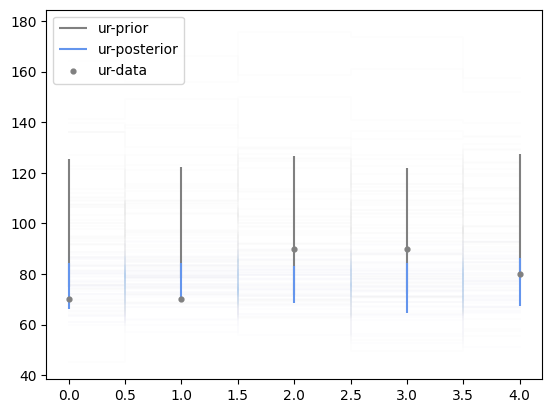

In [6]:
# ur Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.Expected_Data[0].T, alpha = 0.01, c = 'grey', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'grey', label='ur-prior');

# ur Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.Expected_Data[0].T, alpha = 0.01, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='ur-posterior')

# Observations
plt.scatter(np.arange(nBins), ur_obs, c = 'grey', s=12, zorder = 999, label = "ur-data")

plt.legend(loc='upper left')